<a href="https://colab.research.google.com/github/akilawickey/IT-5437/blob/main/Assignment1_IT5437.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np, cv2, matplotlib.pyplot as plt, math, os
plt.rcParams['figure.dpi'] = 120

def read_rgb(path):
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None: raise FileNotFoundError(path)
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

def show(img, title="", gray=False, size=(4,4)):
    plt.figure(figsize=size)
    if gray: plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    else:    plt.imshow(img)
    plt.title(title); plt.axis('off'); plt.show()

def hist(img, title="Histogram"):
    plt.figure(figsize=(5,3))
    plt.hist(img.ravel(), bins=256, range=(0,255))
    plt.title(title); plt.xlabel("Intensity"); plt.ylabel("Count"); plt.show()

def apply_lut(img_u8, lut256):
    lut = np.asarray(lut256, dtype=np.uint8)
    return cv2.LUT(img_u8, lut)

def piecewise_lut(points):
    xs, ys = zip(*points)
    xs, ys = np.array(xs, float), np.array(ys, float)
    lut = np.zeros(256, float)
    i = 0
    while i < len(xs)-1:
        x0,y0,x1,y1 = xs[i],ys[i],xs[i+1],ys[i+1]
        if x1==x0:
            lut[int(x0)] = y0; i+=1; continue
        m = (y1-y0)/(x1-x0)
        xr = np.arange(int(np.ceil(x0)), int(np.floor(x1))+1)
        lut[xr] = m*(xr-x0)+y0
        i+=1
    lut[:int(xs[0])]  = ys[0]
    lut[int(xs[-1]):] = ys[-1]
    return np.clip(lut,0,255).astype(np.uint8)

def to_lab(rgb): return cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
def to_rgb_from_lab(lab): return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
def to_hsv(rgb): return cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
def to_rgb_from_hsv(hsv): return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

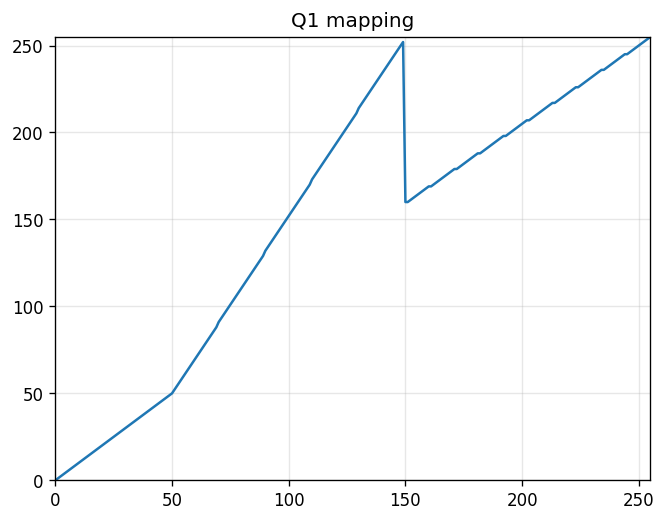

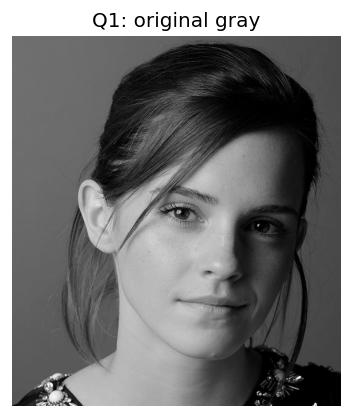

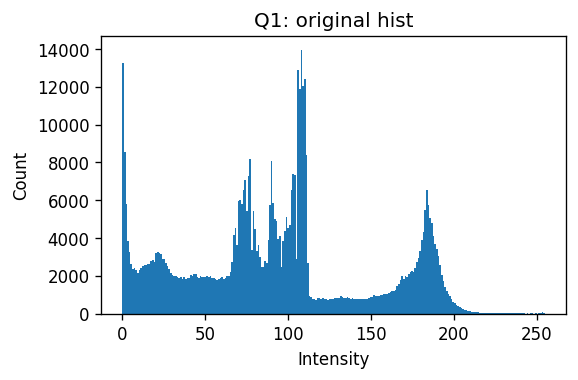

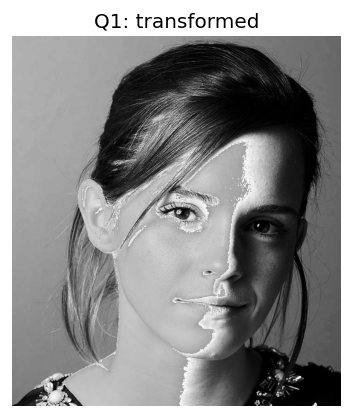

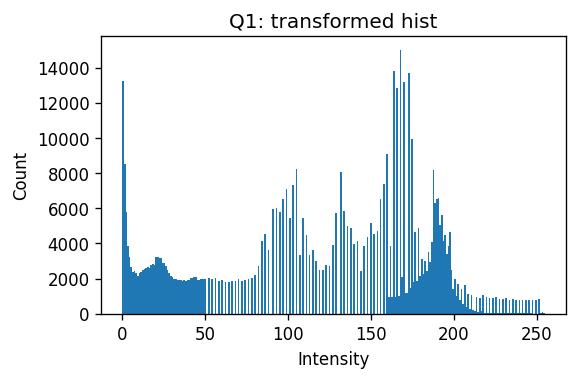

In [11]:
# Q1

# image file load
face_path = "/content/drive/MyDrive/cv images/emma.jpg"

rgb = read_rgb(face_path)
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

# Points read from Fig.1(a): includes a deliberate jump at x=150
points = [(0,0), (50,50), (150,255), (150,160), (255,255)]
lut = piecewise_lut(points)

x = np.arange(256); plt.plot(x,lut); plt.title("Q1 mapping"); plt.xlim(0,255); plt.ylim(0,255); plt.grid(True,alpha=.3); plt.show()

out = apply_lut(gray, lut)
show(gray, "Q1: original gray", True); hist(gray, "Q1: original hist")
show(out,  "Q1: transformed", True);  hist(out,  "Q1: transformed hist")

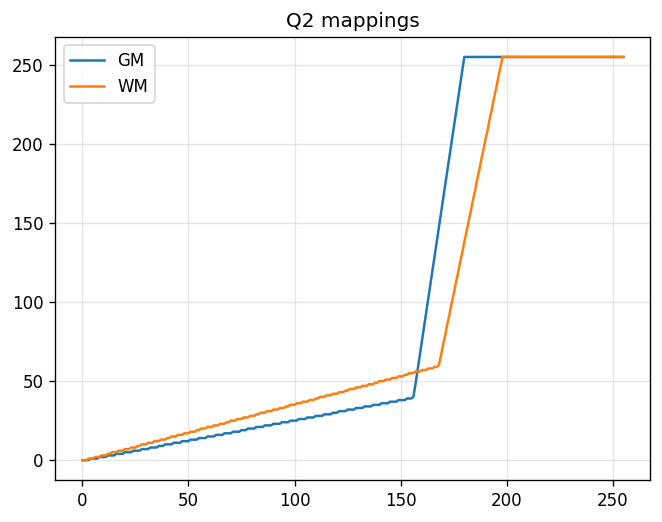

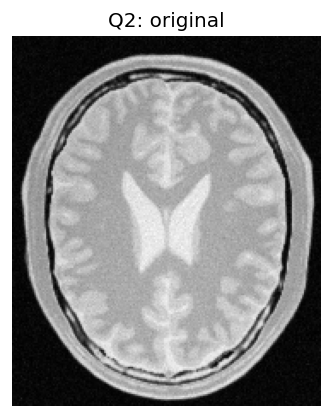

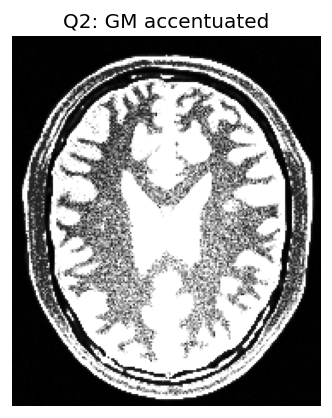

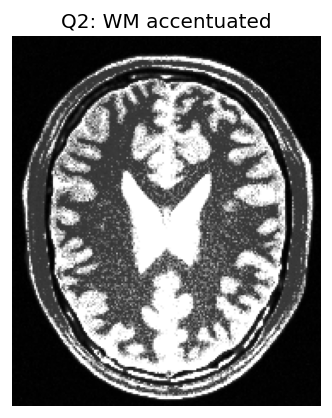

In [12]:
#Q2

brain_path = "/content/drive/MyDrive/cv images/brain_proton_density_slice.png"
brain = cv2.cvtColor(read_rgb(brain_path), cv2.COLOR_RGB2GRAY)
p = np.percentile(brain, [10,25,40,55,70,85,95])
p10,p25,p40,p55,p70,p85,p95 = p

# Heuristics: GM ~ mid; WM ~ higher-mid
G1,G2 = int(p40), int(p70)
W1,W2 = int(p55), int(p85)

gm_points = [(0,0),(G1,40),(G2,255),(255,255)]
wm_points = [(0,0),(W1,60),(W2,255),(255,255)]
lut_gm = piecewise_lut(gm_points)
lut_wm = piecewise_lut(wm_points)

plt.plot(np.arange(256), lut_gm, label="GM"); plt.plot(np.arange(256), lut_wm, label="WM")
plt.title("Q2 mappings"); plt.legend(); plt.grid(True,alpha=.3); plt.show()

brain_gm = apply_lut(brain, lut_gm)
brain_wm = apply_lut(brain, lut_wm)

show(brain, "Q2: original", True)
show(brain_gm, "Q2: GM accentuated", True)
show(brain_wm, "Q2: WM accentuated", True)

Q3 gamma (γ) = 0.544


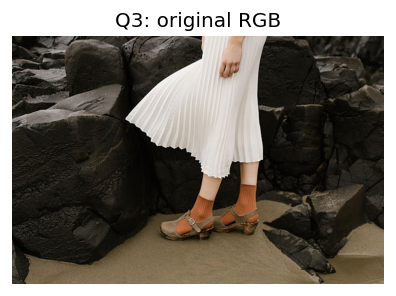

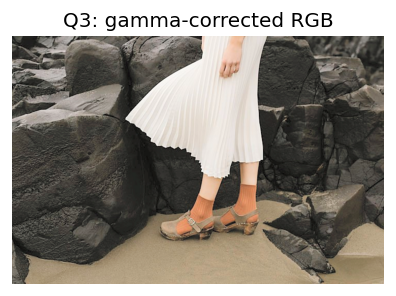

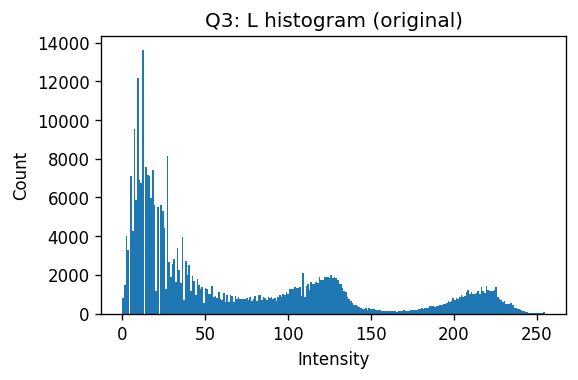

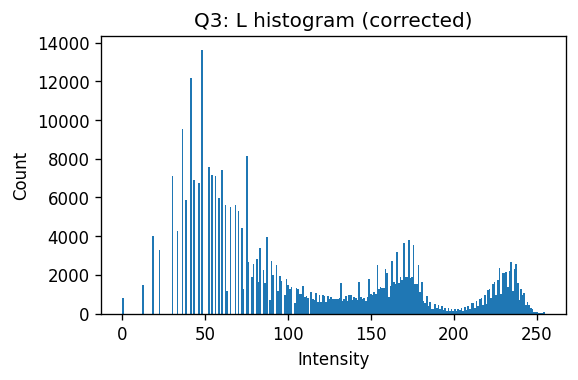

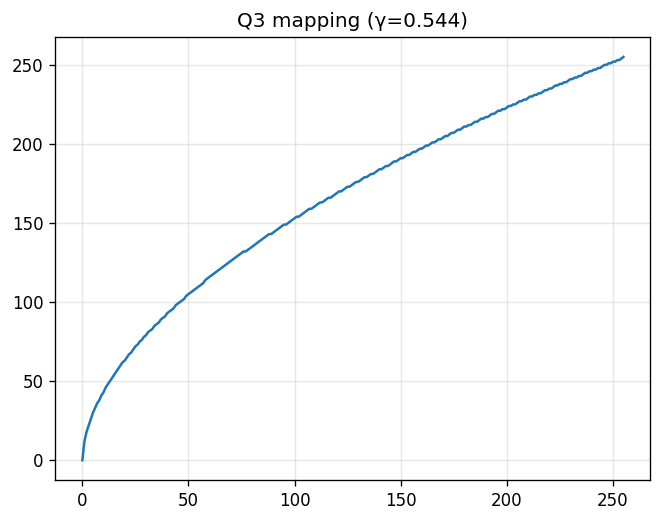

In [13]:
#Q3

q3_path = "/content/drive/MyDrive/cv images/highlights_and_shadows.jpg"

TARGET_MEAN = 0.50                       # set your target brightness of L
MANUAL_GAMMA = None                      # e.g., 0.8 or 1.2 to override

rgb = read_rgb(q3_path)
lab = to_lab(rgb); L,a,b = cv2.split(lab)
Ln = L.astype(np.float32)/255.0
mu = max(1e-6, float(Ln.mean()))
auto_gamma = math.log(TARGET_MEAN)/math.log(mu)
gamma = MANUAL_GAMMA if MANUAL_GAMMA is not None else auto_gamma

x = np.arange(256, dtype=np.float32)/255.0
lut = np.clip((x**gamma)*255.0, 0,255).astype(np.uint8)
L2 = apply_lut(L, lut)
rgb2 = to_rgb_from_lab(cv2.merge([L2,a,b]))

print(f"Q3 gamma (γ) = {gamma:.3f}")
show(rgb,  "Q3: original RGB")
show(rgb2, "Q3: gamma-corrected RGB")
hist(L,  "Q3: L histogram (original)")
hist(L2, "Q3: L histogram (corrected)")

plt.plot(np.arange(256), lut); plt.title(f"Q3 mapping (γ={gamma:.3f})"); plt.grid(True,alpha=.3); plt.show()


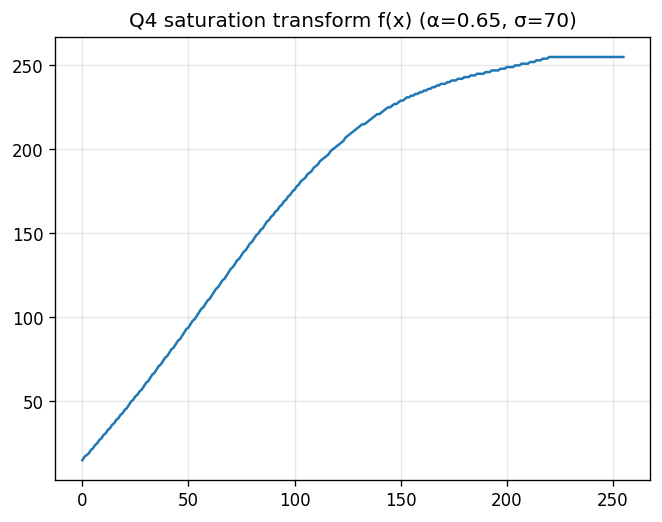

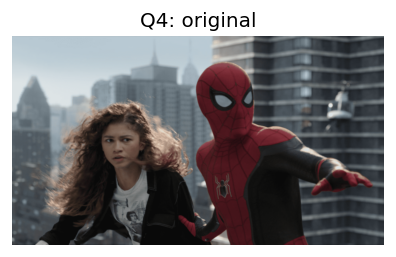

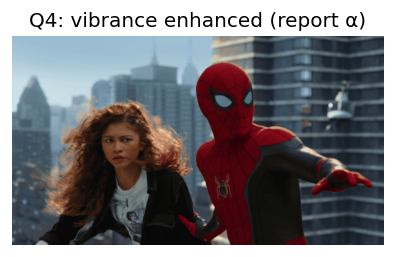

In [28]:
#Q4

q4_path = "/content/drive/MyDrive/cv images/spider.png"
ALPHA = 0.65

rgb = read_rgb(q4_path)
hsv = to_hsv(rgb); H,S,V = cv2.split(hsv)
x = np.arange(256, dtype=np.float32)
lut = np.minimum(x + ALPHA*128.0*np.exp(-((x-128.0)**2)/(2.0*(70.0**2))), 255.0).astype(np.uint8)

S2 = apply_lut(S, lut)
rgb_vib = to_rgb_from_hsv(cv2.merge([H,S2,V]))

plt.plot(np.arange(256), lut);
plt.title(f"Q4 saturation transform f(x) (α={ALPHA}, σ=70)"); plt.grid(True,alpha=.3);
plt.show()

show(rgb,     "Q4: original")
show(rgb_vib, "Q4: vibrance enhanced (report α)")

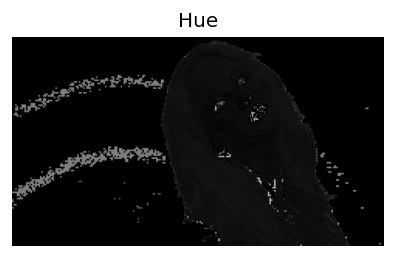

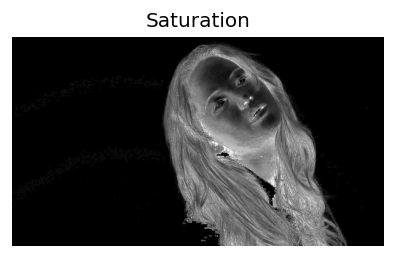

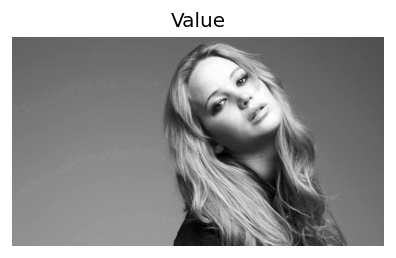

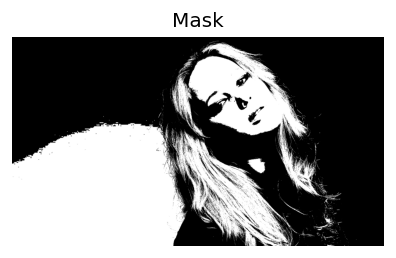

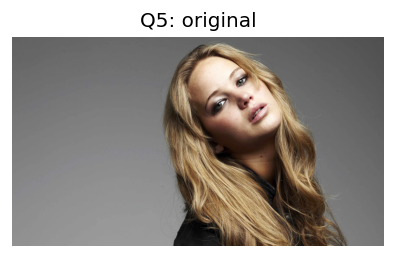

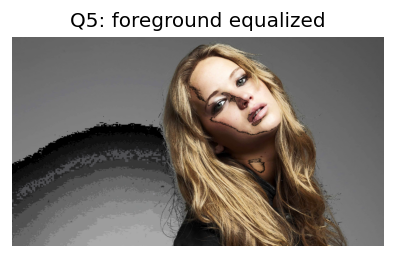

In [16]:
#Q5

q5_path = "/content/drive/MyDrive/cv images/jeniffer.jpg"
PLANE = "V"                               # "V" or "S"
FLIP_MASK = False                         # set True if subject is darker

rgb = read_rgb(q5_path)
hsv = to_hsv(rgb); H,S,V = cv2.split(hsv)
show(H, "Hue", True); show(S, "Saturation", True); show(V, "Value", True)

plane = V if PLANE=="V" else S
_, mask = cv2.threshold(plane, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
if FLIP_MASK: mask = cv2.bitwise_not(mask)
show(mask, "Mask", True)

# Foreground histogram & CDF on Value channel
vals = V[mask>0]
hist_fg = np.bincount(vals, minlength=256)
cdf = np.cumsum(hist_fg); N = int(cdf[-1]) if cdf[-1]>0 else 1
cdf_min = cdf[np.nonzero(cdf)][0] if np.any(hist_fg) else 0
lut = np.round(255.0*(cdf - cdf_min)/max(1,(N-cdf_min))).astype(np.uint8).clip(0,255)

V2 = V.copy(); V2[mask>0] = lut[V[mask>0]]
rgb_eq = to_rgb_from_hsv(cv2.merge([H,S,V2]))
show(rgb,    "Q5: original")
show(rgb_eq, "Q5: foreground equalized")


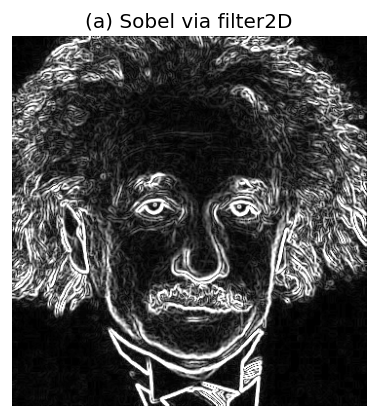

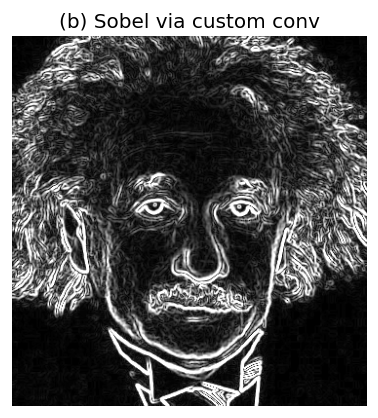

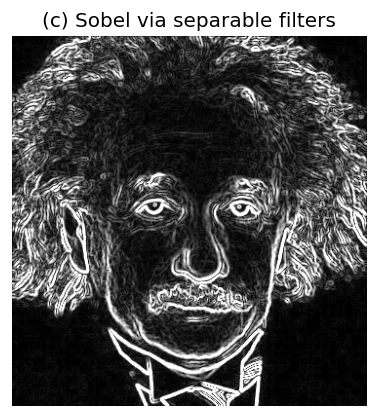

In [19]:
#Q6

q6_path = "/content/drive/MyDrive/cv images/einstein.png"

gray = cv2.cvtColor(read_rgb(q6_path), cv2.COLOR_RGB2GRAY)

# (a) Using filter2D with Sobel kernels
Kx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]], np.float32)
Ky = Kx.T
gx = cv2.filter2D(gray, cv2.CV_32F, Kx)
gy = cv2.filter2D(gray, cv2.CV_32F, Ky)
mag_a = cv2.convertScaleAbs(np.hypot(gx,gy))
show(mag_a, "(a) Sobel via filter2D", True)

# (b) Write your own convolution (valid padding by replication)
def conv2(img, k):
    pad = k.shape[0]//2
    imgp = cv2.copyMakeBorder(img, pad,pad,pad,pad, cv2.BORDER_REPLICATE)
    out = np.zeros_like(img, np.float32)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            out[i,j] = np.sum(imgp[i:i+k.shape[0], j:j+k.shape[1]] * k)
    return out
gx2 = conv2(gray.astype(np.float32), Kx)
gy2 = conv2(gray.astype(np.float32), Ky)
mag_b = cv2.convertScaleAbs(np.hypot(gx2,gy2))
show(mag_b, "(b) Sobel via custom conv", True)

# (c) Separable filtering: [[1],[2],[1]] * [1,0,-1]
v = np.array([[1],[2],[1]], np.float32)
h = np.array([[1,0,-1]],  np.float32)
gx3 = cv2.sepFilter2D(gray, cv2.CV_32F, h, v)  # (h then v)
gy3 = cv2.sepFilter2D(gray, cv2.CV_32F, v, h)  # (v then h)
mag_c = cv2.convertScaleAbs(np.hypot(gx3,gy3))
show(mag_c, "(c) Sobel via separable filters", True)


Q7 normalized SSD (NN): 0.01205793209373951
Q7 normalized SSD (Bilinear): 0.01018405519425869


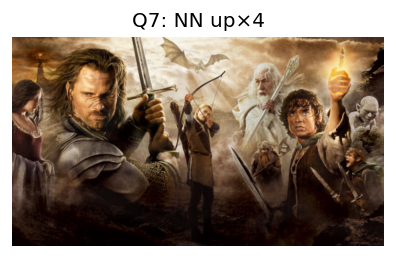

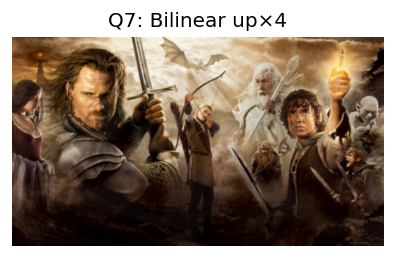

In [21]:
#Q7

orig_path = "/content/drive/MyDrive/cv images/im01.png"     # original
small_path= "/content/drive/MyDrive/cv images/im01small.png"  # provided small (zoomed-out)

def zoom_nn(img, s):
    h,w = img.shape[:2]
    H,W = int(h*s), int(w*s)
    return cv2.resize(img, (W,H), interpolation=cv2.INTER_NEAREST)

def zoom_bilinear(img, s):
    h,w = img.shape[:2]
    H,W = int(h*s), int(w*s)
    return cv2.resize(img, (W,H), interpolation=cv2.INTER_LINEAR)

orig  = read_rgb(orig_path)
small = read_rgb(small_path)

up_nn  = zoom_nn(small, 4.0)
up_bl  = zoom_bilinear(small, 4.0)

# crop to common size
H,W = min(orig.shape[0], up_nn.shape[0]), min(orig.shape[1], up_nn.shape[1])
o = orig[:H,:W].astype(np.float32)
n = up_nn[:H,:W].astype(np.float32)
b = up_bl[:H,:W].astype(np.float32)

def nssd(a,b):
    return float(np.sum((a-b)**2) / (np.sum(a**2) + 1e-6))

print("Q7 normalized SSD (NN):", nssd(o,n))
print("Q7 normalized SSD (Bilinear):", nssd(o,b))
show(up_nn, "Q7: NN up×4")
show(up_bl, "Q7: Bilinear up×4")

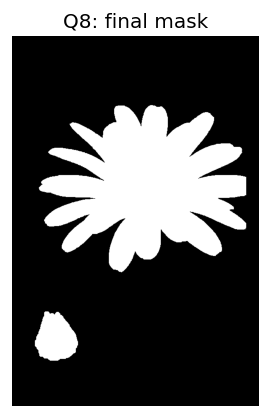

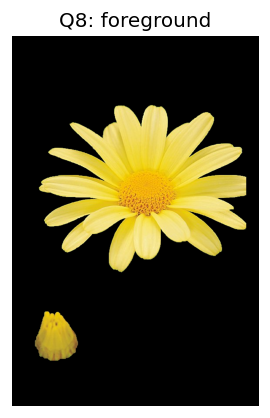

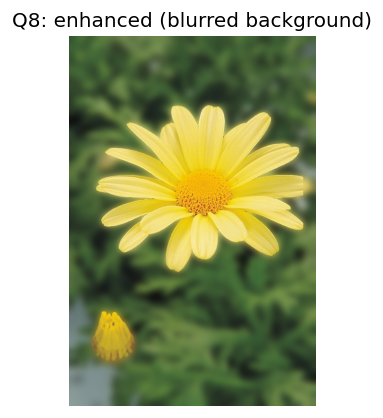

In [23]:
#Q8

img_path_q8 = "/content/drive/MyDrive/cv images/daisy.jpg"  # <-- Fig.7 path
rgb = read_rgb(img_path_q8)

# Rough rectangle around subject (adjust margins if needed)
h,w = rgb.shape[:2]
rect = (int(0.05*w), int(0.05*h), int(0.90*w), int(0.90*h))
mask = np.zeros((h,w), np.uint8)
bgdModel = np.zeros((1,65), np.float64)
fgdModel = np.zeros((1,65), np.float64)
cv2.grabCut(cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR), mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
fg_mask = np.where((mask==cv2.GC_FGD) | (mask==cv2.GC_PR_FGD), 255, 0).astype(np.uint8)

fg = cv2.bitwise_and(rgb, rgb, mask=fg_mask)
bg = cv2.GaussianBlur(rgb, (0,0), sigmaX=8, sigmaY=8)
comp = cv2.bitwise_and(bg, bg, mask=255-fg_mask) + cv2.bitwise_and(rgb, rgb, mask=fg_mask)

show(fg_mask, "Q8: final mask", True); show(fg, "Q8: foreground")
show(comp, "Q8: enhanced (blurred background)")

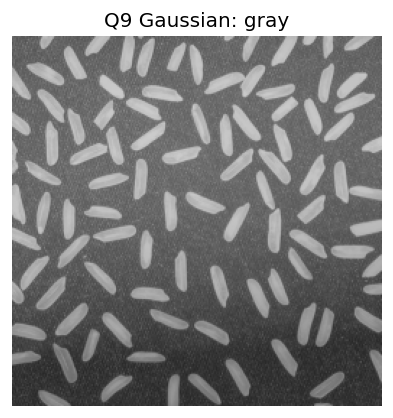

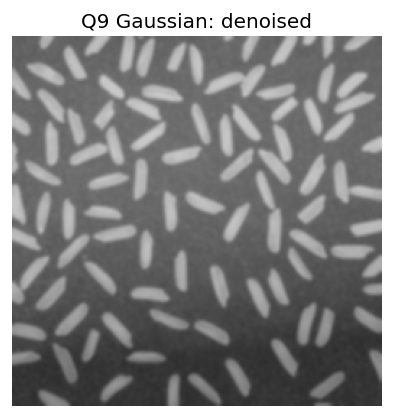

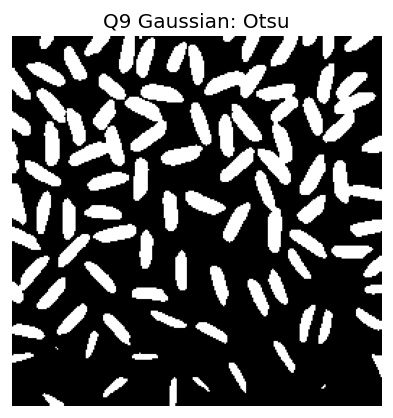

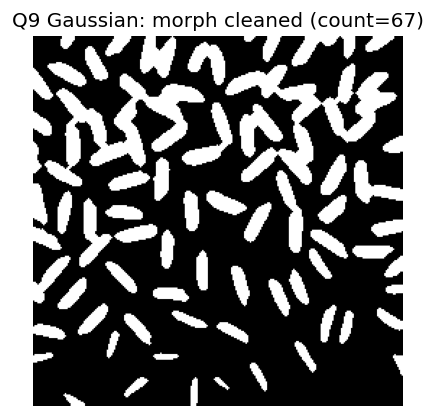

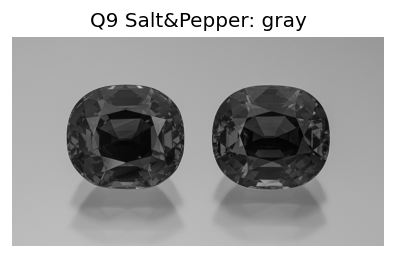

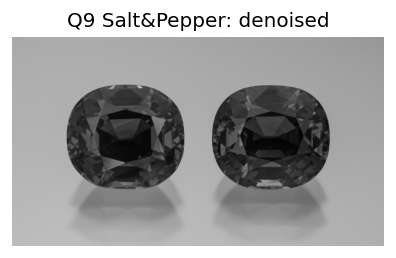

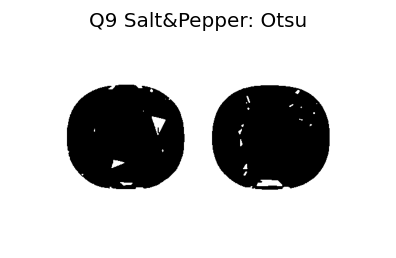

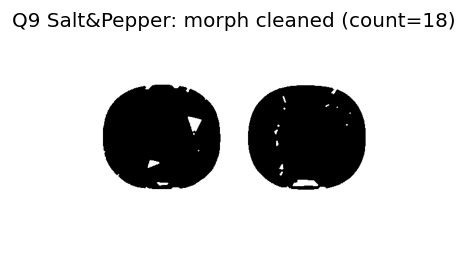

In [37]:
#Q9

img_gauss = "/content/drive/MyDrive/cv images/rice.png"  # Fig.8(a)
img_sp    = "/content/drive/MyDrive/cv images/salt_n_pepper.jpg"       # Fig.8(b)

def preprocess_and_count(path, sp=False):
    gray = cv2.cvtColor(read_rgb(path), cv2.COLOR_RGB2GRAY)
    den  = cv2.medianBlur(gray, 3) if sp else cv2.GaussianBlur(gray, (5,5), 0)
    _,th = cv2.threshold(den, 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # assume grains bright; ensure foreground white
    if np.mean(den[th==255]) < np.mean(den[th==0]): th = 255-th
    # morphology: open small specks, close small holes
    kern = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    clean = cv2.morphologyEx(th, cv2.MORPH_OPEN, kern, iterations=1)
    clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kern, iterations=2)
    n, labels = cv2.connectedComponents(clean)
    return gray, den, th, clean, n-1

for path, name, sp in [(img_gauss,"Gaussian",False),(img_sp,"Salt&Pepper",True)]:
    gray,den,th,clean,count = preprocess_and_count(path, sp)
    show(gray,  f"Q9 {name}: gray", True)
    show(den,   f"Q9 {name}: denoised", True)
    show(th,    f"Q9 {name}: Otsu", True)
    show(clean, f"Q9 {name}: morph cleaned (count={count})", True)

Q10 pixel areas: [np.int32(168984), np.int32(29), np.int32(12), np.int32(3), np.int32(3), np.int32(6), np.int32(330), np.int32(5), np.int32(3), np.int32(19), np.int32(2), np.int32(25), np.int32(126), np.int32(78)]
Q10 estimated areas (mm^2): [np.float64(1192.3511039999999), np.float64(0.204624), np.float64(0.084672), np.float64(0.021168), np.float64(0.021168), np.float64(0.042336), np.float64(2.32848), np.float64(0.03528), np.float64(0.021168), np.float64(0.134064), np.float64(0.014112), np.float64(0.1764), np.float64(0.889056), np.float64(0.550368)]


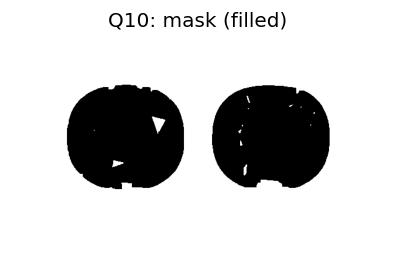

In [31]:
#Q10

img_path_q10 = "/content/drive/MyDrive/cv images/sapphire.jpg"   # Fig.9 path

FOCAL_MM = 8.0
OBJECT_DIST_MM = 480.0
PIXEL_PITCH_MM = 0.0014

rgb = read_rgb(img_path_q10)
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
# simple segmentation (tweak if needed)
blur = cv2.GaussianBlur(gray,(5,5),0)
_, th = cv2.threshold(blur, 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# ensure gems are white
if np.mean(gray[th==255]) < np.mean(gray[th==0]): th = 255-th

# fill holes
th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, np.ones((5,5),np.uint8), iterations=2)
num, labels, stats, _ = cv2.connectedComponentsWithStats(th, connectivity=8)

areas_px = [s[cv2.CC_STAT_AREA] for i,s in enumerate(stats) if i!=0]
print("Q10 pixel areas:", areas_px)

scale = (OBJECT_DIST_MM/FOCAL_MM)**2 * (PIXEL_PITCH_MM**2)
areas_mm2 = [a*scale for a in areas_px]
print("Q10 estimated areas (mm^2):", areas_mm2)

show(th, "Q10: mask (filled)", True)